# Simple model

This notebook shows a simple neural network model and some basic data preparation. I started out too late and didn't even scratch the surface of possibilities. Thorough feature engineering and a working stack could significantly increase the acc. 

In [1]:
#Loading in libraries
pacman::p_load(tidyverse, dplyr, ggplot2, ggthemes, RColorBrewer, fastDummies, janitor, cowplot, MLmetrics, rfVarImpOOB,
                repr, BBmisc, devtools, reticulate, Rcpp, tictoc, data.table, corrplot, ggrepel, tensorflow, keras)

#Loading in train data
#df_train <- read.csv("../input/tabular-playground-series-feb-2022/train.csv", nrow = 40000)
df_train <- read.csv("../input/tabular-playground-series-feb-2022/train.csv")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘binaryLogic’



rfVarImpOOB installed



# Exploring the data

**Group proportions**

In [2]:
pie_maker <- function(df, names) {

#Piechart
df_pie <- data.frame(c(as.numeric(prop.table(table(df[, length(df)])))), unique(df[, length(df)]))
    colnames(df_pie) <- names

df_pie[, length(df_pie)] <- as.factor(df_pie[, length(df_pie)])

#Label positions
df_pie <- df_pie %>% 
  arrange(desc(df_pie[, length(df_pie)])) %>%
  mutate(prop = df_pie[, length(df_pie)-1] / sum(df_pie[, length(df_pie)-1]) *100) %>%
  mutate(ypos = cumsum(prop)- 0.5*prop)

df_pie <- df_pie %>%
cbind(roundup = round(df_pie$prop, digits = 3))



options(repr.plot.width = 14, repr.plot.height = 9)
# Basic piechart
ggplot(df_pie, aes(x =" ", y = prop, fill = df_pie[, 2])) +
  geom_bar(stat = "identity", width = 2, color = "white") +
  coord_polar("y", start = 0) +
  theme_void() + 
  geom_label_repel(data = df_pie,
                   aes(y = ypos, label = paste0(roundup, "%")),
                   size = 7.5, nudge_x = 1.75, show.legend = FALSE) +
 scale_fill_manual(values = c(brewer.pal(n = 8, name = 'Pastel1'), brewer.pal(n = 7, name = 'Pastel2')), name = names[2]) +
 theme(legend.key.size = unit(1, 'cm'), 
        legend.key.height = unit(1, 'cm'), 
        legend.key.width = unit(1, 'cm'), 
        legend.title = element_text(size = 12), 
        legend.text = element_text(size = 11))
}

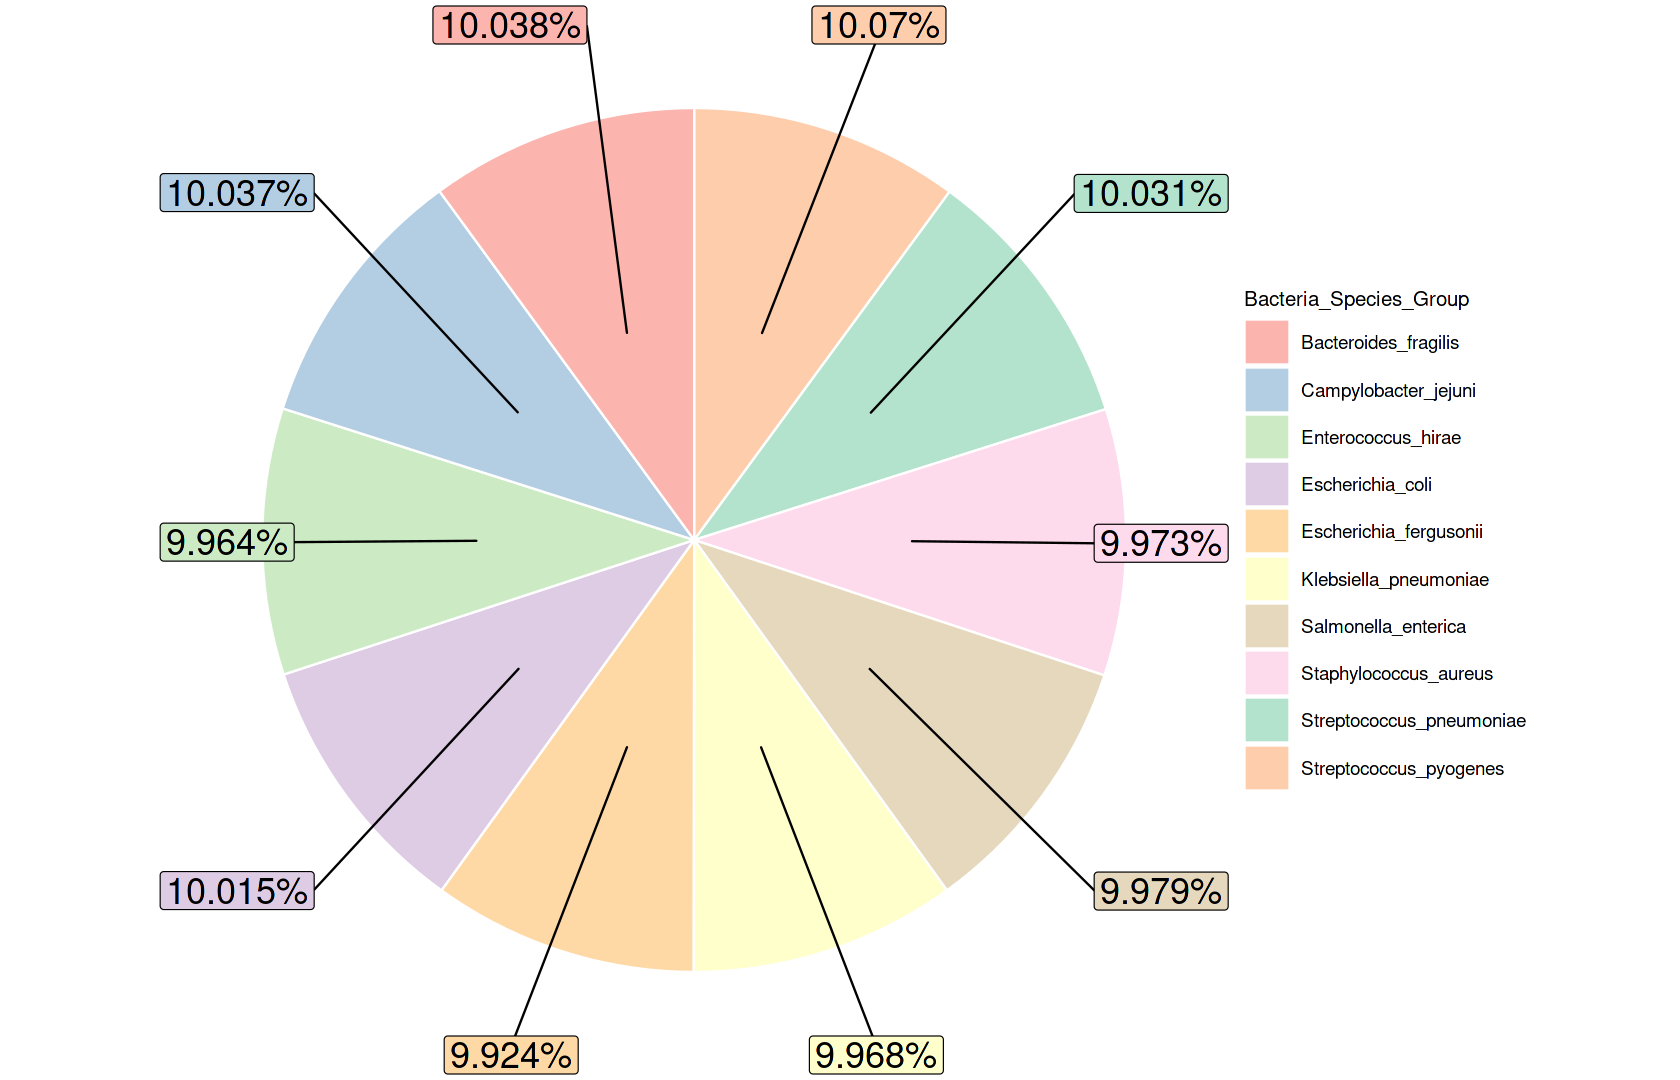

In [3]:
#Pie chart proportions with duplicates
pie_maker(df_train, c("Bacteria_Species", "Bacteria_Species_Group"))

Both train and test sets contain duplicated rows. First, they will get removed from the train set.

In [4]:
#Finding duplicates
df_train <- df_train %>%
    group_by(across(2:length(df_train))) %>%
    add_tally() %>%
    ungroup()

colnames(df_train)[length(df_train)] <- c("weight")

#Removing duplicates
df_train <- df_train[!duplicated(df_train[, -c(1, length(df_train))]), ]

#Setting row_ids
df_train$row_id <- c(1:nrow(df_train))

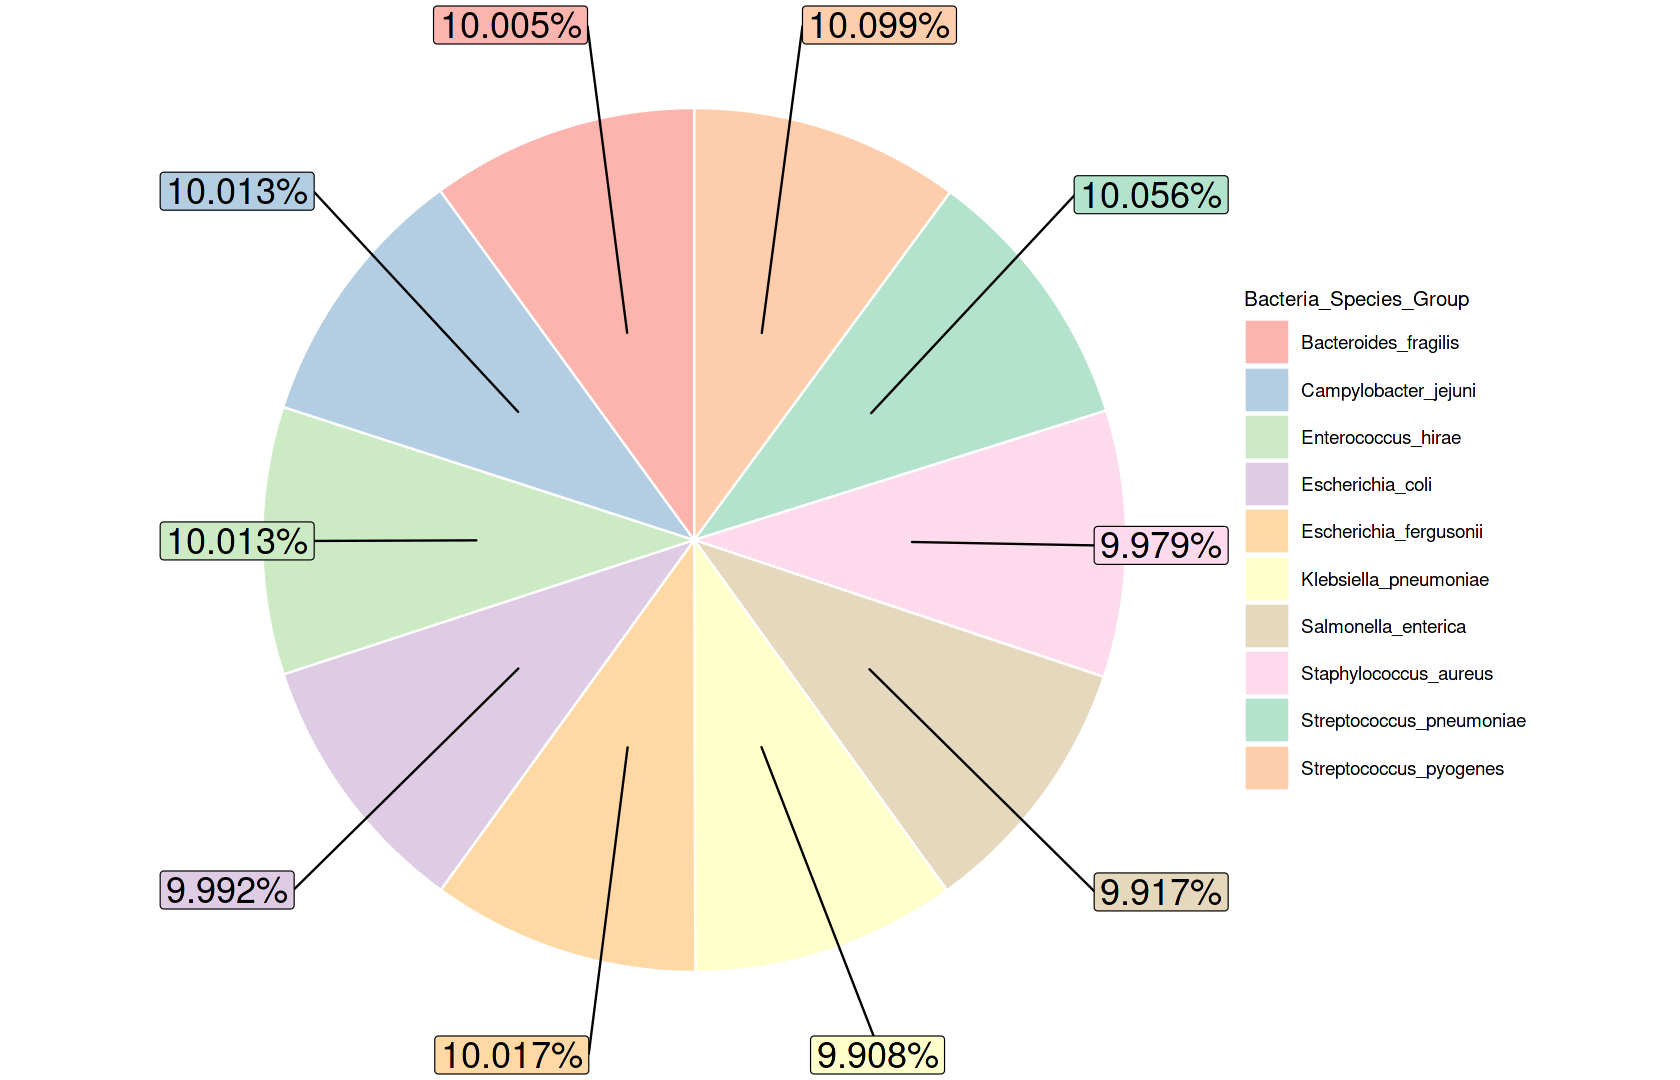

In [5]:
#Pie chart without duplicates (and weights)
pie_maker(df_train[, -length(df_train)], c("Bacteria_Species", "Bacteria_Species_Group"))

The distribution of classes is preserved after removing duplicate rows.

**How unique are these features?**

In [6]:
data.frame(lapply(apply(df_train[, -c(1, length(df_train))], 2, unique),length)) %>%
 pivot_longer(c(1:length(df_train[, -c(1, length(df_train))])), names_to = "variables_ascending", values_to = "unique_values_low") %>%
 arrange(unique_values_low) %>%
 cbind(
 data.frame(lapply(apply(df_train[, -c(1, length(df_train))], 2, unique),length)) %>%
 pivot_longer(c(1:length(df_train[, -c(1, length(df_train))])), names_to = "variables_descending", values_to = "unique_values_high") %>%
 arrange(desc(unique_values_high))
          ) %>%
 head(10)

,variables_ascending,unique_values_low,variables_descending,unique_values_high
,<chr>,<int>,<chr>,<int>
1,target,10,A4T3G1C2,12494
2,A0T0G10C0,14,A3T4G2C1,11984
3,A0T0G0C10,18,A2T2G3C3,11942
4,A0T10G0C0,18,A4T3G2C1,11779
5,A1T0G9C0,19,A3T4G1C2,11415
6,A0T0G9C1,21,A4T4G1C1,11361
7,A0T1G0C9,21,A2T1G3C4,11346
8,A10T0G0C0,22,A1T2G4C3,11177
9,A0T0G1C9,23,A2T1G4C3,11083


# Data preparation

**Normalizing data**

In [7]:
#Removing the 'row_id' column
df_train <- df_train[, -1]

#Normalizing (in this instance scaling) data
#df_train <- df_train %>%
#   mutate(across(c(1:(length(df_train)-2)), ~BBmisc::normalize(.x, method = 'range', range = c(0,1))))

#Normalizing (standardizing) data
df_train <- df_train %>%
    mutate(across(c(1:(length(df_train)-2)), ~BBmisc::normalize(.x, method = 'standardize')))

#Separating weights
weights <- df_train$weight
df_train <- df_train[, -length(df_train)]


#Cne-hot encoding target variable
df_train <- df_train %>%
    mutate(dummy_cols(df_train$target))

#Removing original 'target'
df_train <- df_train[, -c(287:288)]

#Fixing colnames
colnames(df_train)[287:296] <- str_replace(colnames(df_train)[287:296], ".data_", "")

**Out of folds predictor**

In [8]:
#Dataset = data.frame object, xy = list containing positions of feature and target variables,
#model = nn keras model, again = repeated cv, k = how many folds,
#fit_params = list containing number of epochs and batch size
#sample_weighs = possible weights
#prob_matrix = whether to return probabilities of classes
repeated_cv_predictor <- function(dataset, xy, model, again, k, fit_params, sample_weight = NULL, prob_matrix = NULL) {
    
    #Spltting the data and setting up cv
k_num <- k

dataset <- dataset %>%
    cbind(id = 1:nrow(dataset))

df_of_predictions <- data.frame(id = 1:nrow(dataset))                    

#Pseudo cv loop
for(i in 1:again) {
    
set.seed(i)
dataset <- dataset[sample(nrow(dataset)), ] 
    
outer_predict <- data.frame()

    for(j in 1:k_num) {      
exclusion_rows <- c(((j-1)*(floor(nrow(dataset)/k_num))+1):(floor((nrow(dataset)/k_num))*j))

if(j == k_num){
    exclusion_rows <- c(((j-1)*(floor(nrow(dataset)/k_num))+1):(floor((nrow(dataset)/k_num))*j+nrow(dataset)%%k_num)) #Adding the remainder of rows to the last batch
}

        
    model %>% keras::fit(x = data.matrix(dataset[-exclusion_rows, c(xy$x)], rownames.force = NA),
                                   y = data.matrix(dataset[-exclusion_rows, c(xy$y)], rownames.force = NA),
                                   epochs = fit_params$epochs,
                                   batch_size = fit_params$batch_size,
                                   sample_weight = sample_weight[-exclusion_rows]
                                   )

        
if(missing(prob_matrix) || prob_matrix == FALSE){
    inner_predict <- data.frame(
        predictions = max.col(predict(model, data.matrix(dataset[exclusion_rows, xy$x], rownames.force = NA))),
        id = dataset[exclusion_rows, length(dataset)], true_target = max.col(dataset[exclusion_rows, xy$y]))
        }

else if(!missing(prob_matrix) && prob_matrix == TRUE) {
                inner_predict <- data.frame(predict(model, data.matrix(dataset[exclusion_rows, xy$x], rownames.force = NA)))
            
            inner_predict <- inner_predict %>%
                cbind(id = dataset[exclusion_rows, length(dataset)], true_target = max.col(dataset[exclusion_rows, xy$y]))
}
        
        outer_predict <- rbind(outer_predict, inner_predict)
        
        rm(inner_predict)
        gc()
        
        bacterial_model %>% load_model_weights_hdf5('./bacterial.h5') #'Resetting' layer weights
}
    outer_predict <- outer_predict %>%
         arrange(id)
    
    
    df_of_predictions <- df_of_predictions %>%
        cbind(outer_predict[, -((length(outer_predict)-1):length(outer_predict))])  #Adding predicted classes / probabilities
}
df_of_predictions <- df_of_predictions[, -1] %>%
    cbind(target = outer_predict[, length(outer_predict)])  #Adding the true target variable
    

return(df_of_predictions)
                                        }

# Model creation

In [9]:
#NN model
bacterial_input <- layer_input(shape = c(dim(df_train)[[-1]]-10), name = 'bacterial_input')


bacterial_output <- bacterial_input %>%
    layer_dense(units = 512, activation = 'relu') %>%
    layer_dropout(rate = 0.2) %>%
    layer_dense(units = 256, activation = 'relu') %>%
    layer_dropout(rate = 0.15) %>%
    layer_dense(units = 256, activation = 'relu') %>%
    layer_dropout(rate = 0.1) %>%
    layer_dense(units = 128, activation = 'relu') %>%
    layer_dropout(rate = 0.07) %>%
    layer_batch_normalization(
    momentum = 0.99,
    epsilon = 0.001,
    center = TRUE,
    scale = TRUE) %>%
    layer_dense(units = 10, activation = 'softmax')


bacterial_model <- keras_model(
            inputs = c(bacterial_input),
            outputs = c(bacterial_output))


bacterial_model %>% compile(
  optimizer = 'adam',
  loss = 'categorical_crossentropy',
  metrics = 'categorical_accuracy')

bacterial_model %>% save_model_weights_hdf5('./bacterial.h5')



bacterial_model %>% summary()

Model: "functional_1"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
bacterial_input (InputLayer)        [(None, 286)]                   0           
________________________________________________________________________________
dense_4 (Dense)                     (None, 512)                     146944      
________________________________________________________________________________
dropout_3 (Dropout)                 (None, 512)                     0           
________________________________________________________________________________
dense_3 (Dense)                     (None, 256)                     131328      
________________________________________________________________________________
dropout_2 (Dropout)                 (None, 256)                     0           
________________________________________________________________________________
dense_

In [10]:
do_oof = FALSE

if(do_oof == TRUE) {
bacterial_oof_predictions <- repeated_cv_predictor(df_train,
                              xy = list(x = c(1:286), y = c(287:296)),
                              model = bacterial_model,
                              again = 5, k = 10,
                              fit_params = list(epochs = 60, batch_size = 256),
                              sample_weight = weights, prob_matrix = TRUE)

#for(i in 1:(length(bacterial_oof_predictions)-1)) {
#    print(mean(bacterial_oof_predictions[, i] == bacterial_oof_predictions[, length(bacterial_oof_predictions)]))
#}

#print(mean(apply(bacterial_oof_predictions[, 1:(length(bacterial_oof_predictions)-1)], MARGIN = 1, Mode) == bacterial_oof_predictions[, length(bacterial_oof_predictions)]))


#Elongating the data
bacterial_oof_predictions_longer <- bacterial_oof_predictions[, 1:10] %>%
    rbind(setNames(bacterial_oof_predictions[, 11:20], colnames(bacterial_oof_predictions)[1:10])) %>%
    rbind(setNames(bacterial_oof_predictions[, 21:30], colnames(bacterial_oof_predictions)[1:10])) %>%
    rbind(setNames(bacterial_oof_predictions[, 31:40], colnames(bacterial_oof_predictions)[1:10])) %>%
    rbind(setNames(bacterial_oof_predictions[, 41:50], colnames(bacterial_oof_predictions)[1:10])) %>%
    cbind(target = rep(bacterial_oof_predictions[, length(bacterial_oof_predictions)], times = 5))
    
    
}

As far as predicting test data, a simple blend / a stack with probabilities of predicted classes could possibly increase the accuracy. I wasn't able to achieve it in due time with the mode function across rows / created model.

`geom_smooth()` using formula 'y ~ x'



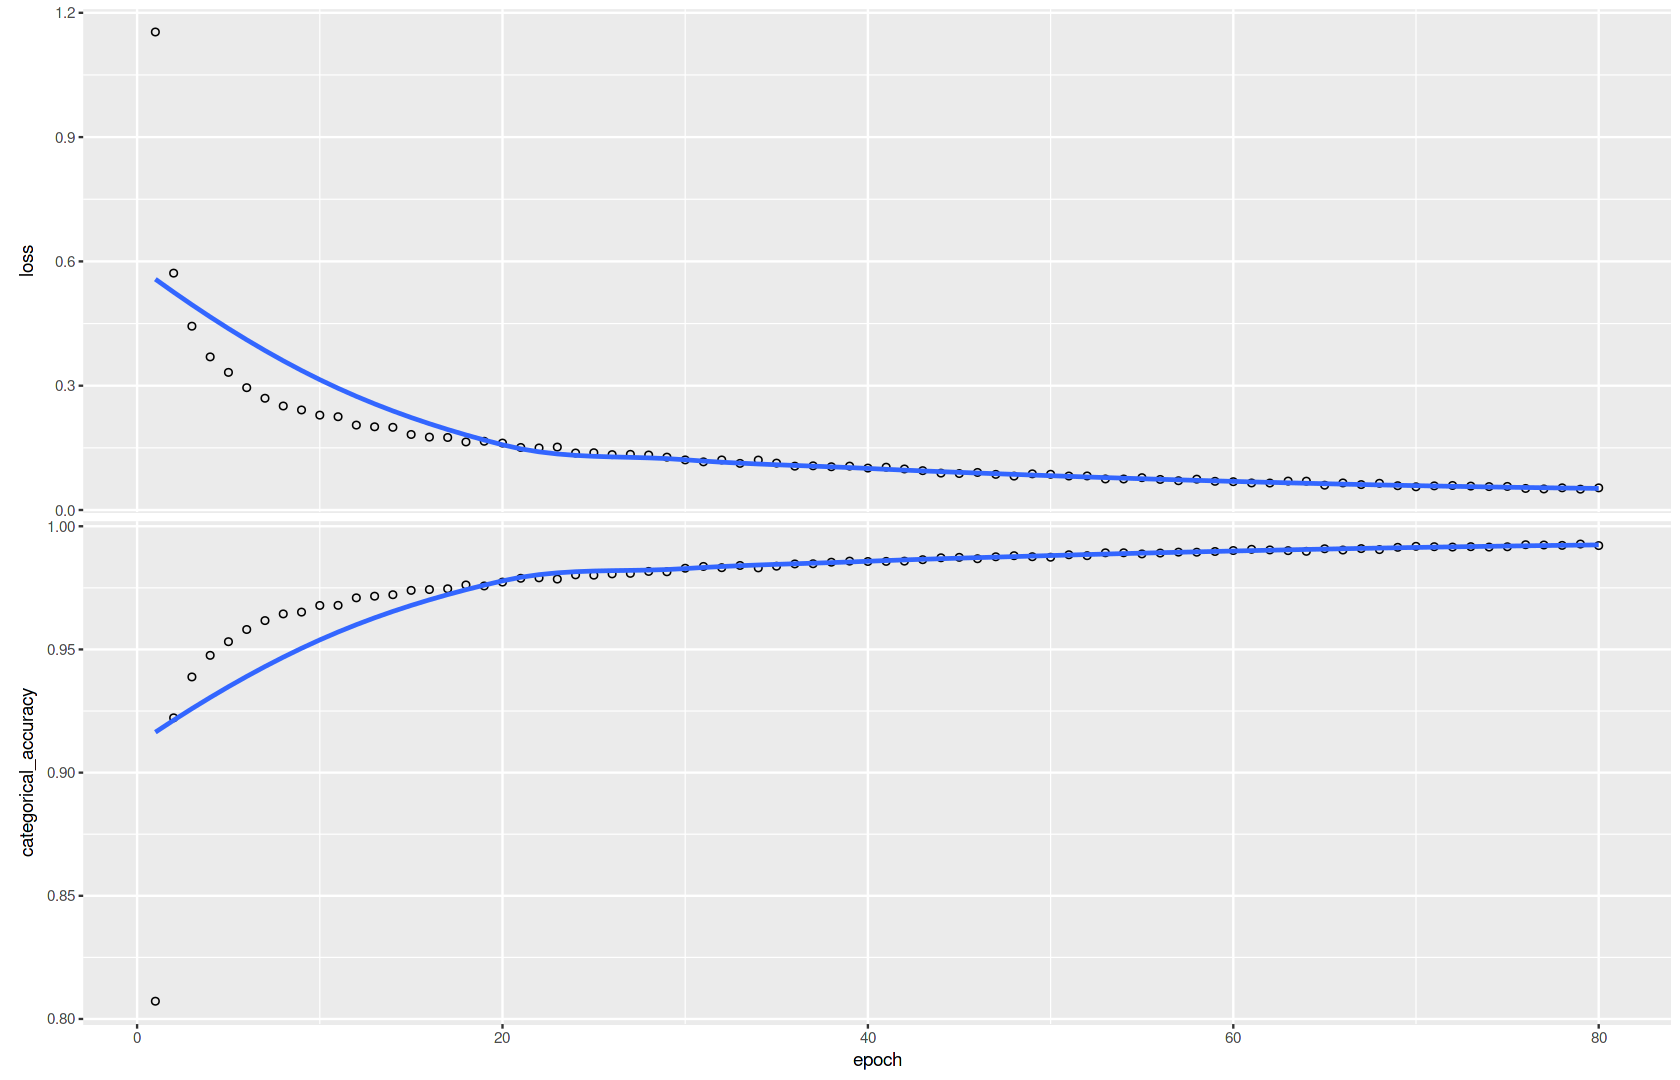

In [11]:
bacterial_history <- bacterial_model %>% fit(
    x = data.matrix(df_train[, -c(287:296)], rownames.force = NA),
    data.matrix(df_train[, c(287:296)], rownames.force = NA),
    epochs = 80,
    batch_size = 256,
    sample_weight = weights
    )

plot(bacterial_history)

#summary(bacterial_history$metrics$val_categorical_accuracy)
#tail(bacterial_history$metrics$val_categorical_accuracy)

**Making predictions**

In [12]:
#Loading in test data
df_test <- read.csv("../input/tabular-playground-series-feb-2022/test.csv")

#Removing the 'row_id' column
df_test <- df_test[, -1]

#Transforming test data
df_test <- df_test %>%
   mutate(across(c(1:length(df_test)), ~BBmisc::normalize(.x, method = 'standardize')))

predict_bact_classes <- max.col(predict(bacterial_model, data.matrix(df_test, rownames.force = NA)))


#Changing factor values back to strings
key <- c(1:10)
names(key) <- colnames(df_train[, 287:296])

predict_bact_classes <- sapply(predict_bact_classes, function(x) {key[x]})

**Creating a submission file**

In [13]:
bacterial_submission <- read.csv("../input/tabular-playground-series-feb-2022/sample_submission.csv")

bacterial_submission$target <- names(predict_bact_classes)

write.csv(bacterial_submission, "./bacterial_submission.csv", quote = FALSE, row.names = FALSE)